# DATA IMPORT

In [22]:
#%% import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.naive_bayes import GaussianNB
import os
from plotnine import ggplot, aes, geom_boxplot, theme_bw, theme, geom_violin, xlab, ylab, ylim
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, theme_bw, theme, xlab, ylab, facet_wrap
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [2]:
#%% set directory
os.getcwd()
os.chdir('C:\\Users\\BIOL0050\\OneDrive - Nexus365\\0.7. Data sci\\MDPI Crops analysis')

In [3]:
#%% import data
data_full = pd.read_csv('220721 all spectral readings.csv')
data_full = pd.DataFrame(data_full)
data = data_full.iloc[:, 4:408]
data = data[data['ln.asn.average'].notna()]

In [4]:
#%% define predictor and response variables for asn and yield
X = data.iloc[:, 2:405].values
X = scaler.fit_transform(X)
y = data[["ln.asn.average"]].values.ravel()
yyield = data[["Grain85%"]].values.ravel()

## ASPARAGINE PREDICTION

In [5]:
# set up neural network model and investigate optimal parameters (for agronomic treatment prediction)
mlp = MLPRegressor(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(50), (50,50), (50,50,50), (100), (100,100), (100,100,100), (300), (300,300), (300,300,300)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 1],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, y)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

KeyboardInterrupt: 

In [6]:
#%% model for predicting agronomic treatment
#define cross-validation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 100)
# define models
model = PLSRegression(n_components = 10)
model2 = MLPRegressor(activation='relu', alpha=1, hidden_layer_sizes=(300, 300), learning_rate = 'adaptive', solver='adam')

In [7]:
# evaluate models
scoring = {'r2':'r2', 'RMSE':'neg_root_mean_squared_error', 'explained_variance': 'explained_variance'}
scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs = -1)
scores2 = cross_validate(model2, X, y, scoring=scoring, cv=cv, n_jobs = -1)

In [46]:
# summarize result
print(scores.keys())
print(np.mean(scores['test_r2']))
print(np.mean(scores2['test_r2']))
print(np.mean(scores['test_RMSE']))
print(np.mean(scores2['test_RMSE']))
print(np.mean(scores['test_explained_variance']))
print(np.mean(scores2['test_explained_variance']))

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_RMSE', 'test_explained_variance'])
0.7125298335841033
0.747614696736182
-0.5407151892030646
-0.5055752935610763
0.7172206192972492
0.7524614581765469


In [9]:
#%% extract and combine model accuracy scores
plsrdf = pd.DataFrame(scores['test_r2'])
plsrdf.columns = ['PLSR']
nndf = pd.DataFrame(scores2['test_r2'])
nndf.columns = ['NN']
fulldata = pd.concat([plsrdf, nndf], axis=1)

In [10]:
print(fulldata)

         PLSR        NN
0    0.626007  0.790566
1    0.737248  0.728102
2    0.691564  0.663859
3    0.710513  0.832115
4    0.756820  0.664641
..        ...       ...
495  0.607947  0.740566
496  0.791324  0.783762
497  0.701581  0.784202
498  0.662905  0.825032
499  0.782416  0.674374

[500 rows x 2 columns]


In [11]:
#%% reshape data
fulldata2 = fulldata.melt(var_name = 'model', value_name = 'Accuracy')

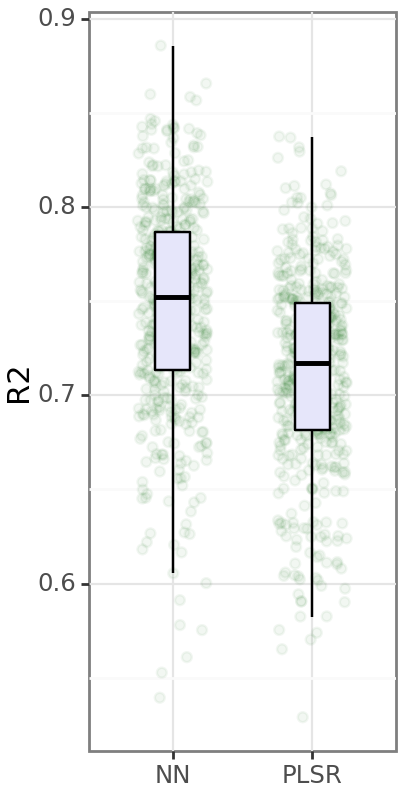

<Figure Size: (200 x 400)>

In [12]:
#%% plot accuracy scores
(ggplot(fulldata2, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + theme(figure_size=(2, 4))
 + xlab("")
 + ylab("R2")
 )

## YIELD PREDICTION

In [52]:
# set up neural network model and investigate optimal parameters (for agronomic treatment prediction)
mlp = MLPRegressor(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(50), (50,50), (50,50,50), (100), (100,100), (100,100,100), (300), (300,300), (300,300,300)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 1, 10],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, yyield)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [13]:
#%% model for predicting agronomic treatment
#define cross-validation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 100)
# define models
yieldmodel = PLSRegression(n_components = 3)
yieldmodel2 = MLPRegressor(activation='tanh', alpha=10, hidden_layer_sizes=(50,50,50), learning_rate = 'constant', solver='adam')

In [14]:
# evaluate models
scoring = {'r2':'r2', 'RMSE':'neg_root_mean_squared_error', 'explained_variance': 'explained_variance'}
yieldscores = cross_validate(yieldmodel, X, yyield, scoring=scoring, cv=cv, n_jobs = -1)
yieldscores2 = cross_validate(yieldmodel2, X, yyield, scoring=scoring, cv=cv, n_jobs = -1)

In [47]:
# summarize result
print(scores.keys())
print(np.mean(yieldscores['test_r2']))
print(np.mean(yieldscores2['test_r2']))

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_RMSE', 'test_explained_variance'])
0.7982039673028114
0.8454388425761065


In [16]:
#%% extract and combine model accuracy scores
yieldplsrdf = pd.DataFrame(yieldscores['test_r2'])
yieldplsrdf.columns = ['PLSR']
yieldnndf = pd.DataFrame(yieldscores2['test_r2'])
yieldnndf.columns = ['NN']
yieldfulldata = pd.concat([yieldplsrdf, yieldnndf], axis=1)

In [17]:
#%% reshape data
yieldfulldata2 = yieldfulldata.melt(var_name = 'model', value_name = 'Accuracy')

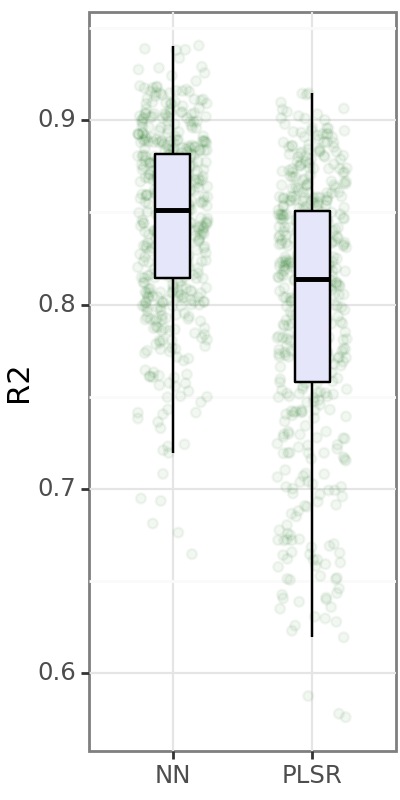

<Figure Size: (200 x 400)>

In [18]:
#%% plot accuracy scores
(ggplot(yieldfulldata2, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + theme(figure_size=(2, 4))
 + xlab("")
 + ylab("R2")
 )

# CLASSIFICATION DATA IMPORT

In [25]:
#read in data
data_full = pd.read_csv('220909 all spectral readings v2.csv')
data_full = pd.DataFrame(data_full)
data_full = data_full[data_full['ln.asn.average'].notna()]
data = data_full.iloc[:, 5:409]
data = data[data['ln.asn.average'].notna()]

In [26]:
#define predictor and response variables for asn and yield
X = data.iloc[:, 2:405]
y = data_full[["binary_sulphur"]].values.ravel()
y2 = data_full[["cultivar"]].values.ravel()

# TREATMENT PREDICTION

In [27]:
# set up neural network model and investigate optimal parameters (for agronomic treatment prediction)
mlp = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(50), (50,50), (50,50,50), (100), (100,100), (100,100,100), (300), (300,300), (300,300,300)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 1, 10],
    'learning_rate': ['constant','adaptive'],
}


clf = GridSearchCV(mlp, parameter_space, n_jobs = -1, cv = 5, verbose = 3)
clf.fit(X, y)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'solver': 'adam'}


In [53]:
#%% model for predicting agronomic treatment
#define cross-validation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 100)
# define models
fertmodel = GaussianNB()
fertmodel2 = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100), learning_rate = 'adaptive', solver='adam')

In [54]:
# evaluate models
scoring = {'bal_acc':'balanced_accuracy'}
fertscores = cross_validate(fertmodel, X, y, scoring=scoring, cv=cv, n_jobs = -1)
fertscores2 = cross_validate(fertmodel2, X, y, scoring=scoring, cv=cv, n_jobs = -1)

In [55]:
# summarize result
print(scores.keys())
print(np.mean(fertscores['test_bal_acc']))
print(np.mean(fertscores2['test_bal_acc']))

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_RMSE', 'test_explained_variance'])
0.7590424855760396
0.8749373172648628


In [56]:
#%% extract and combine model accuracy scores
fertgnbdf = pd.DataFrame(fertscores['test_bal_acc'])
fertgnbdf.columns = ['GNB']
fertnndf = pd.DataFrame(fertscores2['test_bal_acc'])
fertnndf.columns = ['NN']
fertfulldata = pd.concat([fertgnbdf, fertnndf], axis=1)

In [57]:
print(fertfulldata)

          GNB        NN
0    0.764727  0.972222
1    0.667308  0.960000
2    0.863755  0.886897
3    0.777417  0.841518
4    0.746324  0.884897
..        ...       ...
495  0.775253  0.826954
496  0.826265  0.922056
497  0.739832  0.751916
498  0.834449  0.847763
499  0.664062  0.849206

[500 rows x 2 columns]


In [58]:
#%% reshape data
fertfulldata2 = fertfulldata.melt(var_name = 'model', value_name = 'Accuracy')

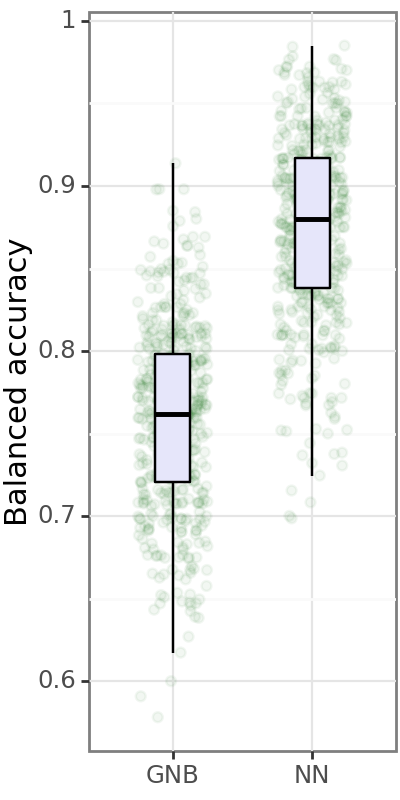

<Figure Size: (200 x 400)>

In [59]:
#%% plot accuracy scores
(ggplot(fertfulldata2, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + theme(figure_size=(2, 4))
 + xlab("")
 + ylab("Balanced accuracy")
 )

# CULTIVAR PREDICTION

In [60]:
# set up neural network model and investigate optimal parameters (for agronomic treatment prediction)
mlp = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(50), (50,50), (50,50,50), (100), (100,100), (100,100,100), (300), (300,300), (300,300,300)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 1, 10],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, y2)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'solver': 'adam'}


In [61]:
#%% model for predicting agronomic treatment
#define cross-validation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 100)
# define models
genomodel = GaussianNB()
genomodel2 = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(300), learning_rate = 'constant', solver='adam')

In [62]:
# evaluate models
scoring = {'bal_acc':'balanced_accuracy'}
genoscores = cross_validate(genomodel, X, y2, scoring=scoring, cv=cv, n_jobs = -1)
genoscores2 = cross_validate(genomodel2, X, y2, scoring=scoring, cv=cv, n_jobs = -1)

In [63]:
# summarize result
print(np.mean(genoscores['test_bal_acc']))
print(np.mean(genoscores2['test_bal_acc']))

0.2652864186318732
0.31706668407350225


In [64]:
#%% extract and combine model accuracy scores
genognbdf = pd.DataFrame(genoscores['test_bal_acc'])
genognbdf.columns = ['GNB']
genonndf = pd.DataFrame(genoscores2['test_bal_acc'])
genonndf.columns = ['NN']
genofulldata = pd.concat([genognbdf, genonndf], axis=1)

In [65]:
print(genofulldata)

          GNB        NN
0    0.253472  0.305998
1    0.287500  0.319907
2    0.271149  0.196825
3    0.261839  0.370370
4    0.340575  0.262566
..        ...       ...
495  0.274684  0.304993
496  0.294417  0.335516
497  0.210651  0.274937
498  0.214649  0.281019
499  0.256576  0.355952

[500 rows x 2 columns]


In [66]:
#%% reshape data
genofulldata2 = genofulldata.melt(var_name = 'model', value_name = 'Accuracy')

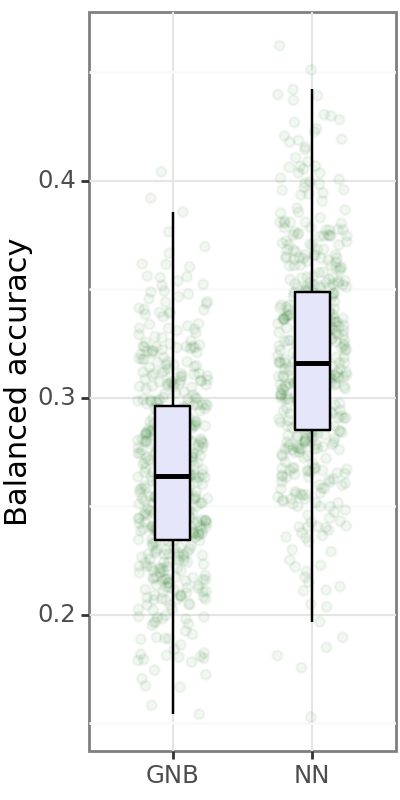

<Figure Size: (200 x 400)>

In [67]:
#%% plot accuracy scores
(ggplot(genofulldata2, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + theme(figure_size=(2, 4))
 + xlab("")
 + ylab("Balanced accuracy")
 )

## PLOTTING TOGETHER

In [68]:
fulldata2['variable'] = "Asparagine"
yieldfulldata2['variable'] = "Yield"
completedata = pd.concat([fulldata2, yieldfulldata2])

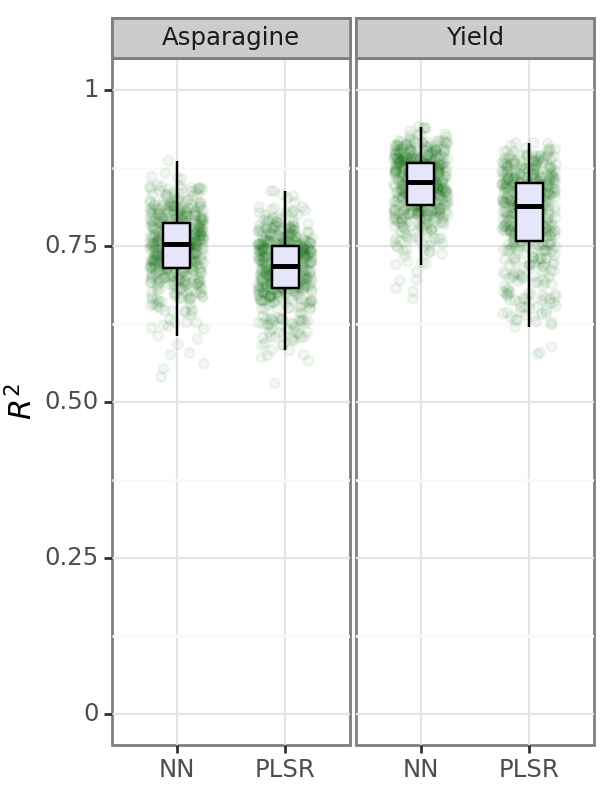

<Figure Size: (300 x 400)>

In [84]:
(ggplot(completedata, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + facet_wrap('variable')
 + theme(figure_size=(3, 4))
 + xlab("")
 + ylab("$R^2$")
 + ylim(0, 1)
 )

In [75]:
fertfulldata2['variable'] = "Sulphur treatment"
genofulldata2['variable'] = "Genotype"
completedata2 = pd.concat([fertfulldata2, genofulldata2])

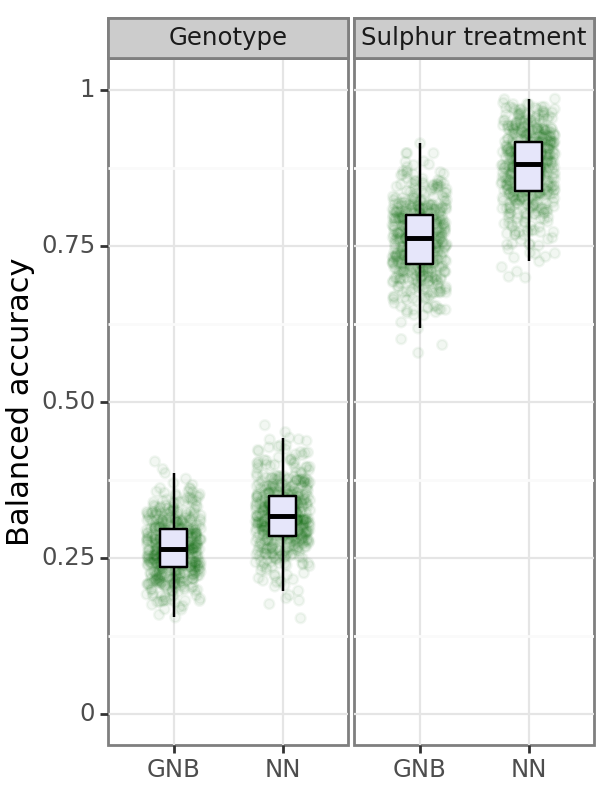

<Figure Size: (300 x 400)>

In [76]:
(ggplot(completedata2, aes(x = 'model', y = 'Accuracy'))
 + geom_jitter(width = 0.25, alpha = 0.05, color = "darkgreen")
 + geom_boxplot(width = 0.25, color = "black", fill = "lavender", outlier_shape = 'x', outlier_colour = '') 
 + theme_bw()
 + facet_wrap('variable')
 + theme(figure_size=(3, 4))
 + xlab("")
 + ylab("Balanced accuracy")
 + ylim(0, 1)
 )